In [6]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using SparseArrays
using ForwardDiff
using OSQP
using RobotDynamics
using RobotZoo: PlanarRocket
using RobotZoo
using StaticArrays
using Plots
using JLD2
using Test
using Statistics

const FD = ForwardDiff;

include("quadrotor.jl");

  Activating environment at `~/Documents/ocrl_hw/Quadrotor_MPC_with_Kalman_Filter/Project.toml`


## Quadrotor Dynamics Model

The derivation of the 3d Quadrotor Dynamics model we use is available in [Lecture 15's Notes](https://github.com/Optimal-Control-16-745/lecture-notebooks/blob/main/Lecture%2015/Lecture%2015.pdf)

$$ 
x = \begin{bmatrix} {}^{N}r \\ q \\ {}^{B}V \\ {}^{B}\omega \end{bmatrix}, \quad
\dot{x} = 
\begin{bmatrix} 
    Q {}^{B}V \\
    \frac{1}{2} L(q) H {}^{B}\omega \\
    \frac{1}{m} {}^{B}F - {}^{B}\omega \times {}^{B}V \\
    J^{-1} ({}^{B}\tau - {}^{B}\omega \times J {}^{B}\omega)
\end{bmatrix}
$$

Where:
$$
{}^{B}F = Q^T
\begin{bmatrix}
0 \\ 0 \\ -mg
\end{bmatrix}
+ 
\begin{bmatrix}
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    k_T & k_T & k_T & k_T
\end{bmatrix} u
$$

$$
{}^{B}\tau = 
\begin{bmatrix}
    0 & s k_T & 0 & -s k_T \\
    -s k_T & 0 & s k_T & 0 \\
    k_m & -k_m & k_m & -k_m
\end{bmatrix} u
$$

Note that a rotation matrix $Q$ can be obtained from a quaternion $q$ via:
$$ 
Q = R^T(q) L(q)
$$

Such that:
$$
\begin{bmatrix} 0 \\ {}^{N}x \end{bmatrix} = Q \begin{bmatrix} 0 \\ {}^{B}x \end{bmatrix}
$$

For more information on the quaternion math, check out `src/quaternions.jl`

The model is defined like so:
![quad_dyn](../media/quadrotor_dynamics_image.png)
![quad_dyn_axes](../media/quadrotor_dynamics_axes_definition.png)

# LQR Controller (baseline)

The LQR formulation we used is a simple linearlization of the system about hover (i.e. all thrust vectors point straight down and sum to counter gravity).

This linearization gives us the following approximation of the system's dynamics:

$$x_{t+1} = A x_{t} + B u_{t}$$

Where A is the state Jacobian and B is the input Jacobian:
$$A = \frac{\partial x_{t+1}}{\partial x_{t}}, \quad B = \frac{\partial x_{t+1}}{\partial u_{t}}$$

This works so long as the quadrotor stays close to the point its dynamics were linearized about.

In [7]:
include("quaternions.jl")
include("dynamics.jl")
include("LQR_controller.jl")
include("quadrotor.jl");
nx = 16
nu = 4
dt = 0.025
T = 5.0
N = Int(T / dt)

model = Quadrotor()

x0 = zeros(nx)
# x0[4:7] .= [  0.9045898, 0.1836784, -0.3379966, 0.1836784] # quat version of (10, 10, 10) [deg] euler angles
x0[4] = 1.0 # enforce unit-norm constraint on quat
uhover = fill(mass * g / nu, nu) 

Q = diagm(ones(nx-1))
# Q[1:3,1:3] .= 100.0*I(3)
# Q[4:6,4:6] .= 1e5*I(3)
R = diagm(ones(nu))

Uref = [copy(uhover) for i = 1:N-1];
tref = LinRange(0.0, T, N);


struct Wind_Struct
    wd::Array{Float64,1} # mean on wind angle
    wm::Array{Float64,1} #mean on wind magnitude
    wind_dir::MVector{3,Float64} # wind direction
    wind_hist::Matrix{Float64} #tracks history of wind for plotting
    wind_type::Bool #keeps track of which version of wind to use(double or single)
    wind_disturbance::Bool #Should we use wind
end


wind_hist = zeros(N,3)
wind = Wind_Struct([0], [0], [0. 0. 0.], wind_hist, false, true)
# x_dot = dynamics(x0, uhover)
A, B = dynamics_jacobians(x0, uhover, dt, wind)
J_attitude = attitude_jacobian(x0)
Ã = J_attitude'*A*J_attitude
B̃ = J_attitude'*B
K_LQR = lqr(Ã, B̃, Q, R, tol=1e-3);

LQR converged in 97 iterations


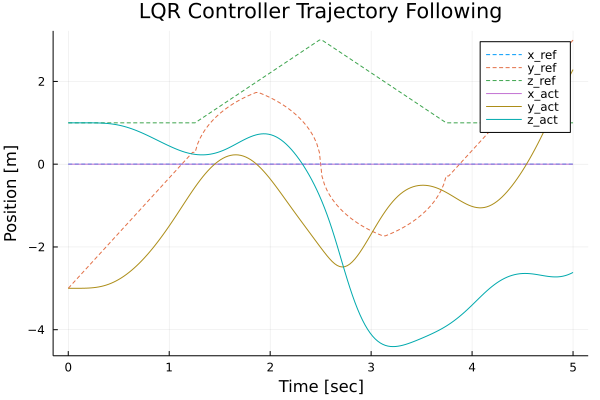

In [8]:
include("quadrotor.jl")
include("dynamics.jl")
X_LQR = [zeros(nx) for i = 1:N]
U_LQR = [copy(uhover) for i = 1:N-1]

# X_line = line_reference(N, dt)
X_line = flip_reference(N, dt)
X_LQR[1][1:4] .= X_line[1][1:4]
# println(X_LQR[1])
# X_LQR[1][4] = 1.0

vals_ref = zeros(N,3)
vals_ref[1,:] .= X_line[1][1:3]
vals_act = zeros(N,3)
vals_act[1,:] .= X_LQR[1][1:3]

for k = 1:N-1
    
    dϕ = ϕ(quat_L(X_line[k][4:7])' * X_LQR[k][4:7])
    dX = vcat([(X_LQR[k] - X_line[k])[1:3]' dϕ' (X_LQR[k] - X_line[k])[8:end]'])'
    
    U_LQR[k] .= U_LQR[k] - (K_LQR * dX)[:,1]
    X_LQR[k+1] .= rk4(X_LQR[k], U_LQR[k], dt, wind)[:,1]
    
    vals_ref[k+1,:] .= X_line[k+1][1:3]
    vals_act[k+1,:] .= X_LQR[k+1][1:3]

end

plot(tref, vals_ref, line=:dash, label=["x_ref" "y_ref" "z_ref"], title="LQR Controller Trajectory Following",
    xlabel="Time [sec]", ylabel="Position [m]")
plot!(tref, vals_act, label=["x_act" "y_act" "z_act"])

In [9]:
# Visualize solution
vis = Visualizer()
set_mesh!(vis, model)
render(vis)


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8704
└ @ MeshCat /home/cory/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8704))

In [10]:
include("quadrotor.jl");
# line_ref = line_reference(N, dt)
# flip_ref = flip_reference(N, dt)
flip_ref = altro_reference_circle(N, dt, model)
# visualize!(vis, model, dt*(N-1), flip_ref)
plot(tref, vals_act, line=:dash, label=["x_ref" "y_ref" "z_ref"], title="LQR Controller Trajectory Following",
    xlabel="Time [sec]", ylabel="Position [m]")
visualize!(vis, model, dt*(N-1), X_LQR)

LoadError: UndefVarError: QuadLQRCost not defined

# MPC Controller

The MPC controller works by solving the following QP:
$$ \begin{align}
    &\text{minimize}_{z} && \frac{1}{2} z^T P z\\
    &\text{subject to} && D z = d \\
    &&& C z \leq d \\
\end{align} $$

where $z$ is the concatenated vector of changes in states and controls from the reference trajectory at each time step. Since we've linearized our system about the point $(x_\text{eq}, u_\text{eq})$, these state and controls are defined relative to this reference. The equality constraints are just the linearized dynamics constraints:

$$ 
\begin{bmatrix} 
    B_k & -I \\ 
      & A_{k+1} & B_{k+1} & -I \\
      &   &   &   & \ddots \\
      &   &   &   & & A_{k+N-1} & B_{k+N-1} -I \\
\end{bmatrix}
\begin{bmatrix} \Delta u_k \\ \Delta x_{k+1} \\ \Delta u_{k+1} \\ \vdots \\ \Delta x_{k+N-1} \\ \Delta u_{k+N-1} \\ \Delta x_{k+N} \end{bmatrix} = 
\begin{bmatrix} -A_k (x_k - x_{ref,k}) \\ 0 \\ \vdots \\ 0 \end{bmatrix}
$$

And the inequality constraints limit the thrust the quadrotor can generate:

$$ 
\begin{bmatrix} u_{min} - u_k \\ u_{min} - u_{k+1} \\ \vdots \\ u_{min} - u_{k+N-1} \end{bmatrix} \leq 
\begin{bmatrix}
    I(m) \\
    0(n+m) & I(m) \\
    & 0(n+m) & I(m) \\
    &&& \ddots \\
    &&&& I(m) & 0(n)
\end{bmatrix}
\begin{bmatrix} \Delta u_k \\ \Delta x_{k+1} \\ \Delta u_{k+1} \\ \vdots \\ \Delta x_{k+N-1} \\ \Delta u_{k+N-1} \\ \Delta x_{k+N} \end{bmatrix} \leq 
\begin{bmatrix} u_{max} - u_k \\ u_{max} - u_{k+1} \\ \vdots \\ u_{max} - u_{k+N-1} \end{bmatrix}
$$

The cost matrix $P$ is defined as:
$$
P = \begin{bmatrix}
R \\
& Q \\
&& \ddots \\
&&& R \\
&&&& Q_f
\end{bmatrix}
$$

In [33]:
include("dynamics.jl")
include("quadrotor.jl")
include("quaternions.jl")

const n = state_dim(model)
const m = control_dim(model)

line_ref = line_reference(N, dt)
flip_ref = flip_reference(N, dt)
flip_ref = simple_flip_reference(N, dt)

Uref = [copy(uhover) for i = 1:N]
umin = -5*uhover[1]
umax = 5*uhover[1]
wind_hist = zeros(N,3)
wind = Wind_Struct([0], [0], [0. 0. 0.], wind_hist, false, true)
A = []
B = []

for i=1:N
#     angle = angle_of_rotation_q(flip_ref[1][4:7])
#     thrust_des = uhover / cos(angle*2)
#     clamp!(thrust_des, umin, umax)
#     Uref[i] = thrust_des
    
    # linearize state dynamics about trajectory
    A_i, B_i = dynamics_jacobians(flip_ref[i],Uref[i],dt, wind)
    # convert state linearizations to 3 parameter attitude rep
    J_attitude = attitude_jacobian(flip_ref[i])
    Ã_i = J_attitude'*A_i*J_attitude
    B̃_i = J_attitude'*B_i
    push!(A, Ã_i)
    push!(B, B̃_i) 
end

In [34]:
include("MPC.jl")
include("quaternions.jl")
include("quadrotor.jl")
include("kalman_filter.jl")
include("dynamics.jl")

# NOTE: these are defined above by LQR 
nx = 16

Q = 1.0*I(nx-1)
# Q[1:3,1:3] *= 10
# Q[4:7,4:7] *= 10 # attitude
# Q[1:2] *= 0.05 
# Q[8:end] *= 10 # vel and angular vel
# Q[11,11] *= 0.01 # x angular vel
R = 1e-5*I(nu)
Qf = 1.0*I(nx-1)
# Qf[1:3,1:3] *= 1e3
Nmpc = 50

x0 = zeros(nx)
for i=1:7
    x0[i] = flip_ref[1][i]
end

# x0[14:16] .= 1.0


mpc = build_MPC_QP(flip_ref, Uref, tref, A, B, Q, R, Qf);
X_mpc_true, X_mpc_KF, U_mpc, t_mpc, wind_hist = simulate(model, x0, mpc, A, B, tf=T, online_linearization=false, wind_disturbance=true);

Beginning simulation...
1
[0.024999999999999998 0.0 0.0; 0.0 0.024999999999999998 0.0; 0.0 0.0 0.024999999999999998]
0.0004420839324299808
2
[0.02499996962381959 1.6826264643940562e-5 3.514910750599885e-5; -1.68795930484008e-5 0.02499996579723887 3.773541941877081e-5; -3.5123528653281886e-5 -3.775922862584108e-5 0.024999946687788106]
59.287605630464554
3
[0.02499986849463407 3.6894767608208085e-5 7.512809933408481e-5; -3.58035338030688e-5 0.024997359482971132 -0.0003609780357368787; -7.565415758237882e-5 0.00036086831355116873 0.02499727213439415]
46.47977497970678
4
[0.02499959583572477 6.464283151549618e-5 0.0001279446331613079; -6.0475034962816116e-5 0.024986875767246567 -0.0008074881627762379; -0.00012996640507074428 0.0008071652979107672 0.024986621296378134]
42.28517895284574
5
[0.024999070631428276 0.00010027316508969894 0.000191519016724097; -8.93500780429516e-5 0.0249603087371794 -0.0014052492766816723; -0.00019685210558896803 0.0014045121644155356 0.02495973381889275]
40.8731

[0.024496769774266902 0.004092838857432322 0.0028561009985028363; -0.003762691101084221 0.024544479606165334 -0.0029000317409363934; -0.0032788338481922184 0.002411790634301798 0.024666414961872225]
40.338190825848095
43
[0.02447848300976029 0.0041517177693842465 0.002927009308117145; -0.003974832929625174 0.024624321147865755 -0.0016861317958288499; -0.003163037430564108 0.0011855827605674395 0.02477073113384658]
40.34297398044519
44
[0.024461765890596565 0.0042005520632304545 0.0029962583322585058; -0.004190316766857572 0.024643981812915744 -0.0003390104197015173; -0.0030105498425710255 -0.00017049908854073291 0.024817474589798945]
40.34826716410583
45
[0.024446904828120626 0.004238662589459369 0.0030631205781710014; -0.004402209450622652 0.02458405418772697 0.0011154945987451566; -0.0028230279994241473 -0.0016301953765289687 0.024786538177578425]
40.3536797555235
46
[0.02443421770773039 0.0042655404062766356 0.003126377937841325; -0.004603780379766781 0.024429066269022196 0.00265054

[0.02458556694925522 0.004486368884473569 0.0006499187398066315; 0.0034618686381099736 -0.020895286282183418 0.0132816398228182; 0.0029266647041359256 -0.01297146780553684 -0.021170146739484395]
40.34106863679507
85
[0.024551884514438495 0.004654130759442581 0.0007375855844436354; 0.003745338153900002 -0.02164836661688095 0.011929803388858644; 0.0028596172658701636 -0.011605465250794877 -0.021957579177231762]
40.34069891275357
86
[0.0245129433392394 0.004835784364785574 0.0008548646378702002; 0.004028815803236396 -0.0222918737047614 0.010575471944497034; 0.0028078911264497954 -0.010231673467519877 -0.022636876415235777]
40.34060283758019
87
[0.02446831054358059 0.005029414336611723 0.001003375268625244; 0.00431491621062036 -0.02283228563982681 0.009223224526314982; 0.002771872294401512 -0.008853889072620143 -0.02321475783851845]
40.34038664336076
88
[0.0244220456242279 0.005214214412680573 0.0011728792974886972; 0.004591703401422509 -0.0232781489381315 0.007876783416365097; 0.002734948

[0.010189765277454334 -0.019397953320200986 -0.012036841184335895; 0.022763644457265045 0.009631126551688605 0.003749507367057006; 0.0017278029084435685 -0.012488352004047246 0.021588231486531738]
40.92394182847357
127
[0.009150482108788105 -0.018747522099487258 -0.013776694303590888; 0.023109476406961177 0.009034224307408995 0.0030554384173438875; 0.002687173361675361 -0.013853233427934883 0.02063648119996471]
40.90376325447198
128
[0.008135485343686511 -0.018121774994767723 -0.015179397692326598; 0.02334377787086301 0.00868893860606947 0.0021380233210022484; 0.003725902565378716 -0.014869510669212927 0.019748737467479044]
40.88193892766582
129
[0.0071719198895509526 -0.01755382068111834 -0.01629190556898035; 0.02349159653024602 0.00846495343881756 0.0012207047299328724; 0.00465926749262513 -0.01565909051248706 0.01892306247447232]
40.852822863603606
130
[0.006279417107918921 -0.017072938909783668 -0.01714885140182876; 0.023561761826642883 0.008351398214186182 0.0003132187825800868; 0

[0.005978702799642445 -0.022190433866305488 -0.00984072879712012; 0.020760908368701744 0.009926251966762271 -0.009770066608438141; 0.01257933930579898 -0.005835604178447873 0.020801584284529807]
40.3585340427341
169
[0.00616970052779593 -0.02234728101684738 -0.009355959560576785; 0.02082534702560286 0.009825198799333572 -0.009735010054115908; 0.0123790038442977 -0.00539115924403397 0.021040334168876774]
40.34933441982527
170
[0.006336509490426502 -0.022492596443315367 -0.008884361678832824; 0.02092293576196269 0.009704540315979206 -0.009646383343011974; 0.012127631789340385 -0.004990500452224578 0.021284160153553534]
40.33963552550997
171
[0.00648007663234174 -0.022627021888694643 -0.00842772812798039; 0.021045740348806147 0.009570259374198243 -0.009512466567114342; 0.011835771383887127 -0.004629050155645839 0.021528735441122316]
40.329667709836365
172
[0.0066021972824763415 -0.022751195858041296 -0.00798712601806955; 0.021186826588798894 0.009427325785077033 -0.009340449106720975; 0.0

In [35]:
visualize!(vis, model, dt*(N-1), X_mpc_KF)

In [36]:
# Visualize solution
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /home/cory/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8702))

In [37]:
include("quadrotor.jl")
visualize!(vis, model, dt*(N-1), X_mpc_KF)
# visualize!(vis, model, dt*(N-1), flip_ref)

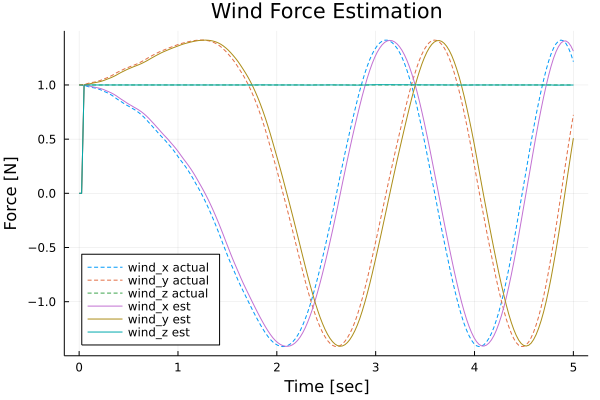

In [38]:
include("plotter.jl")
plot_wind_tracking(X_mpc_KF, wind_hist)

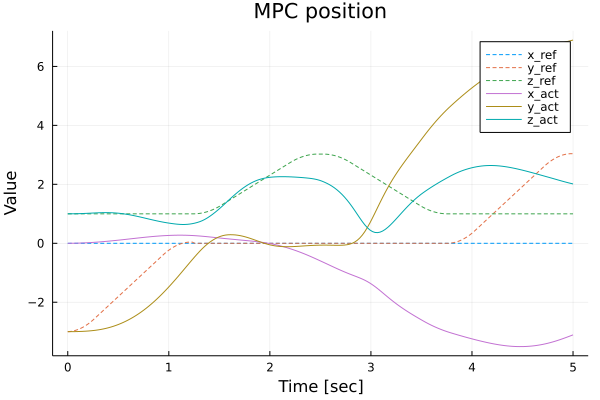

In [39]:
include("plotter.jl")
labs = ["x", "y", "z"]
indices = 1:3
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC position")

In [40]:
ω = [1 2 3]
test = hat(ω)
a = exp.(test)

3×3 Matrix{Float64}:
  1.0       0.0497871  7.38906
 20.0855    1.0        0.367879
  0.135335  2.71828    1.0

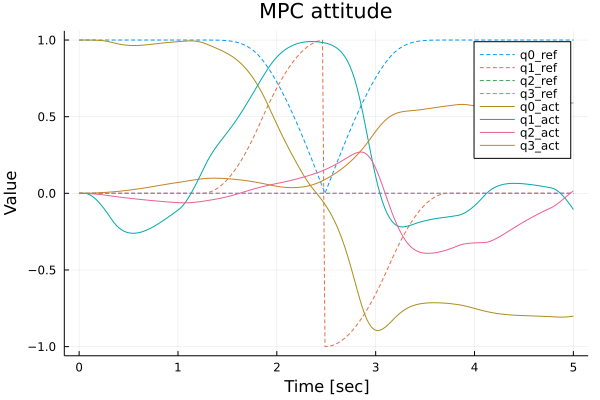

In [41]:
labs = ["q0", "q1", "q2", "q3"]
indices = 4:7
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC attitude")

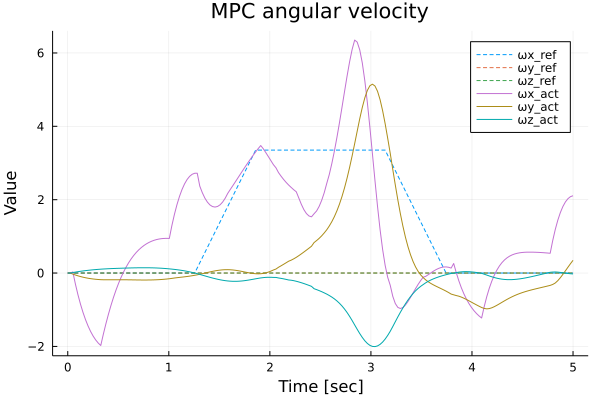

In [42]:
labs = ["ωx", "ωy", "ωz"]
indices = 11:13
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC angular velocity")

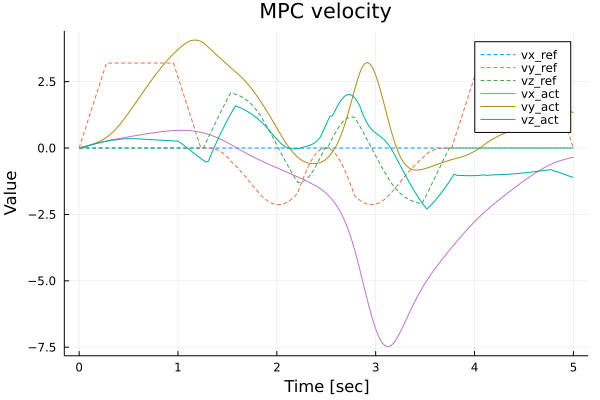

In [43]:
labs = ["vx", "vy", "vz"]
indices = 8:10
plot_vals(flip_ref, X_mpc_KF, indices, labs, "MPC velocity")